In [26]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models


In [27]:
data = pd.read_csv("/kaggle/input/beehive-sounds/all_data_updated.csv")
data.head()


device  hive number                 date  hive temp  hive humidity  \
0       1            5  2022-06-08 14:52:28      36.42          30.29   
1       1            5  2022-06-08 15:51:41      33.56          33.98   
2       1            5  2022-06-08 17:21:53      29.01          42.73   
3       1            5  2022-06-08 18:20:59      30.51          36.74   
4       1            5  2022-06-08 19:20:04      30.32          35.55   

   hive pressure  weather temp  weather humidity  weather pressure  \
0        1007.45         26.68                52              1013   
1        1006.93         25.99                53              1012   
2        1006.68         24.49                56              1012   
3        1006.68         22.97                59              1012   
4        1006.58         21.52                61              1012   

   wind speed  ...  rain    lat    long                   file name  \
0        8.75  ...     0  37.29 -121.95  2022-06-08--14-52-28_1.raw   
1       10.29  ...     0  37.29 -121.95  2022-06-08--15-51-41_1.raw   
2        8.75  ...     0  37.29 -121.95  2022-06-08--17-21-53_1.raw   
3        8.23  ...     0  37.29 -121.95  2022-06-08--18-20-59_1.raw   
4        7.20  ...     0  37.29 -121.95  2022-06-08--19-20-04_1.raw   

   queen presence  queen acceptance frames  target   time  queen status  
0               1                 2      8       0  0.583             0  
1               1                 2      8       0  0.625             0  
2               0                 0      8       1  0.708             1  
3               0                 0      8       1  0.750             1  
4               0                 0      8       1  0.792             1  

[5 rows x 23 columns]

In [28]:
label_map = {
    0: 'queen present or original queen',
    1: 'queen not present',
    2: 'queen present and rejected',
    3: 'queen present and newly accepted'
}

data['queen_label'] = data['queen status'].map(label_map)
data[['file name','queen status','queen_label']].head()


file name  queen status                      queen_label
0  2022-06-08--14-52-28_1.raw             0  queen present or original queen
1  2022-06-08--15-51-41_1.raw             0  queen present or original queen
2  2022-06-08--17-21-53_1.raw             1                queen not present
3  2022-06-08--18-20-59_1.raw             1                queen not present
4  2022-06-08--19-20-04_1.raw             1                queen not present

In [29]:
AUDIO_DIR = "/kaggle/input/beehive-sounds/sound_files/soundfiles/"


In [39]:
import numpy as np
import pandas as pd
import librosa
import os


import os
import pandas as pd

# Ses dosyalarının olduğu klasör
AUDIO_DIR = "/kaggle/input/beehive-sounds/sound_files/sound_files/"

# Klasördeki wav dosyalarını listele
sound_files = os.listdir(AUDIO_DIR)
sound_df = pd.DataFrame(sound_files, columns=["sound_file"])

# sound_file içinden "extracted file name" çıkaralım
# örnek: 2022-06-05--17-41-01_2__segment1.wav  ---> 2022-06-05--17-41-01_2
sound_df["extracted file name"] = sound_df["sound_file"].str.extract(r'^(.*?_\d+)__segment\d+\.\w+$')

# data içindeki "file name" sütunundan da aynı şekilde çıkartalım
data["extracted file name"] = data["file name"].str.extract(r'(.*).raw')

# Eşleşme yapalım
final_df = pd.merge(data, sound_df, on="extracted file name")

# Ses dosyalarının tam path’i
final_df["sound_file_address"] = AUDIO_DIR + final_df["sound_file"]

# Örnek bir queen = 0 ses dosyası alalım
i = 0
queen_presence = 0

file_name = final_df[final_df["queen presence"] == queen_presence]["sound_file_address"].iloc[i]

from IPython.display import Audio
Audio(filename=file_name)


In [41]:
import numpy as np
import librosa

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Ses dosyasını yükle
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # 40 MFCC özelliği çıkar
        return np.mean(mfccs.T, axis=0)  # Ortalama MFCC değerleri
    except Exception as e:
        print(f"Error loading file: {file_path} — {e}")
        return None

X = []
y = []

for idx, row in final_df.iterrows():
    features = extract_features(row["sound_file_address"])
    if features is not None:
        X.append(features)
        y.append(row["queen status"])

X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Features shape: (7100, 40)
Labels shape: (7100,)


In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)



In [45]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-27 14:31:48.514316: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,908 (171.52 KB)

 Trainable params: 43,908 (171.52 KB)

 Non-trainable params: 0 (0.00 B)

aaaaaaaaaa

In [46]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3422 - loss: 12.9966 - val_accuracy: 0.5035 - val_loss: 1.3597
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4672 - loss: 1.4184 - val_accuracy: 0.5035 - val_loss: 1.2205
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4984 - loss: 1.2738 - val_accuracy: 0.5056 - val_loss: 1.1755
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5102 - loss: 1.2137 - val_accuracy: 0.5063 - val_loss: 1.1622
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5026 - loss: 1.2063 - val_accuracy: 0.5085 - val_loss: 1.1341
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5152 - loss: 1.1756 - val_accuracy: 0.5211 - val_loss: 1.1195
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5410 - loss: 1.1380 - val_accuracy: 0.5303 - val_loss: 1.1170
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5514 - loss: 1.1086 - val_accuracy: 0

✅ En iyi Train Accuracy: 0.8035
✅ En iyi Test Accuracy: 0.8507


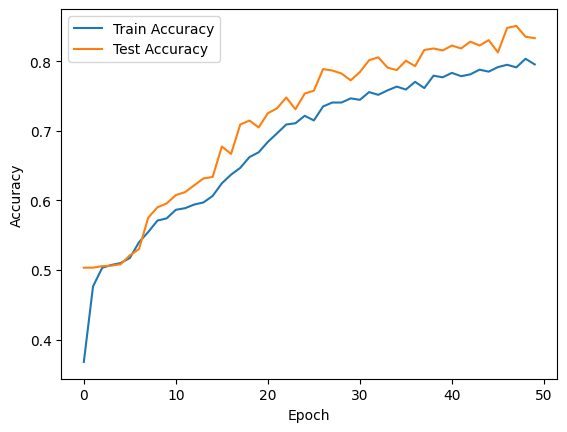

In [49]:
best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])

print(f"✅ En iyi Train Accuracy: {best_train_acc:.4f}")
print(f"✅ En iyi Test Accuracy: {best_val_acc:.4f}")

# Grafik
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import pickle

model.save('bee_model.h5')  # Keras modeli kaydetme

🔹 Veri boyutu: (1275, 24)

🔹 Kolon tipleri:
device                int64
hive number           int64
date                 object
hive temp           float64
hive humidity       float64
hive pressure       float64
weather temp        float64
weather humidity      int64
weather pressure      int64
wind speed          float64
gust speed          float64
weatherID             int64
cloud coverage        int64
rain                  int64
lat                 float64
long                float64
file name            object
queen presence        int64
queen acceptance      int64
frames                int64
target                int64
time                float64
queen status          int64
queen_label          object
dtype: object

🔹 Eksik değerler:
device                0
hive number           0
date                  0
hive temp             0
hive humidity         0
hive pressure         0
weather temp          4
weather humidity      0
weather pressure      0
wind speed            4
gust speed 

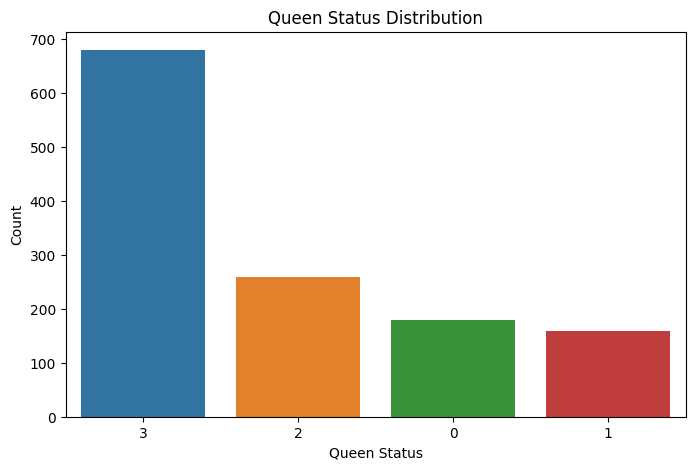

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Genel Bilgiler
# -----------------------------
print("🔹 Veri boyutu:", data.shape)
print("\n🔹 Kolon tipleri:")
print(data.dtypes)
print("\n🔹 Eksik değerler:")
print(data.isnull().sum())

# -----------------------------
# 2. Queen Status Dağılımı
# -----------------------------
plt.figure(figsize=(8,5))
sns.countplot(data=data, x="queen status", order=data["queen status"].value_counts().index)
plt.title("Queen Status Distribution")
plt.xlabel("Queen Status")
plt.ylabel("Count")
plt.show()

In [32]:
import pandas as pd


# Her sütunun benzersiz değer sayısını ve örnek değerleri göster
for col in data.columns:
    unique_values = data[col].nunique()
    samples = data[col].unique()[:5]  # ilk 5 benzersiz değer
    print(f"Column: {col}")
    print(f" - Unique values count: {unique_values}")
    print(f" - Sample values: {samples}\n")


Column: device
 - Unique values count: 2
 - Sample values: [1 2]

Column: hive number
 - Unique values count: 4
 - Sample values: [5 3 4 1]

Column: date
 - Unique values count: 1269
 - Sample values: ['2022-06-08 14:52:28' '2022-06-08 15:51:41' '2022-06-08 17:21:53'
 '2022-06-08 18:20:59' '2022-06-08 19:20:04']

Column: hive temp
 - Unique values count: 1022
 - Sample values: [36.42 33.56 29.01 30.51 30.32]

Column: hive humidity
 - Unique values count: 1151
 - Sample values: [30.29 33.98 42.73 36.74 35.55]

Column: hive pressure
 - Unique values count: 699
 - Sample values: [1007.45 1006.93 1006.68 1006.58 1006.62]

Column: weather temp
 - Unique values count: 828
 - Sample values: [26.68 25.99 24.49 22.97 21.52]

Column: weather humidity
 - Unique values count: 65
 - Sample values: [52 53 56 59 61]

Column: weather pressure
 - Unique values count: 14
 - Sample values: [1013 1012 1011 1014 1015]

Column: wind speed
 - Unique values count: 34
 - Sample values: [ 8.75 10.29  8.23  7.2 

In [ ]:
0:'queen present or original queen',
                                                     1:'queen not present',
                                                     2 :'queen present and rejected', 
                                                     3 :'queen present and newly accepted'})
train['queen status']=train['queen status'].replace({0:'queen present or original queen',
                                                     1:'queen not present',
                                                     2 :'queen present and rejected', 
                                                     3 :'queen present and newly accepted'})